# Leading NPM Libraries

###  Draft RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-10-31_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "LeadingNPMLibraries"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-02_LeadingLibraries.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list only considers projects with libraries published to npm and at least 100 weekly",
                "downloads. The list identifies the peak weekly downloads for a project's most popular package",
                "and awards OP Tokens in proportion to the square root of max weekly downloads. In other words,",
                "it favors more popular libraries but is also fairly egalitarian."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            #'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 1000000

JSON_PATH = DATA_DIR + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
duplicates = oso.check_duplicate_slugs()
print()

Loaded 360 OSS projects from data/RPGF3/2023-10-31_RPGF3_cleaned_applicant_data.json.
Identified 336 unique slugs.



# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
min_downloads = 100
type_id = 9 # downloads

query = f"""
    SELECT
        p.slug,
        max(e.amount)
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_list}')
        AND e."typeId" = {type_id}
        AND e.amount >= {min_downloads}
    GROUP BY
        p.slug;

"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

popular_packages = {project: downloads**.5 for (project,downloads) in results}

In [6]:
# review any potential duplicates

duplicates[duplicates['Slug: Primary'].isin(popular_packages.keys())]

,Project ID,Project Name,Slug: Primary,Payout Address
375,0xd8b0dc71191314a8a0a54b20e63a1a6d843ea350461c...,Rainbow Wallet,rainbow,0x0d9b71891Dc86400aCc7ead08c80aF301cCb3D71
278,0x723da383185924834ea462c791d4e21dac5dedc94ba1...,RainbowKit,rainbow,0x0d9b71891Dc86400aCc7ead08c80aF301cCb3D71
225,0xf162490ee7fc0844a9f2033eb1107cf910df56889ce4...,Waffle,waffle-truefieng,0x4891a0Dbf8FcCa60cc22aa1a69df086090FBCf8F
237,0xf7e99050d67483864a93191708b7ec0b23b2f1a85d5b...,Vaults.fyi,waffle-truefieng,0x4891a0Dbf8FcCa60cc22aa1a69df086090FBCf8F


In [7]:
# check for contributions that map to the wrong Project ID

for slug in popular_packages.keys():
    if slug in duplicates['Slug: Primary'].unique():
        print("Duplicate:")
        project_id = slugs_to_ids[slug]
        
        for _,option in duplicates[duplicates['Slug: Primary']==slug].iterrows():
            project_name = option['Project Name']
            if option['Project ID'] == project_id:
                print(f"Current mapping: {slug} -> {project_id} ({project_name})")
            else:
                print(f"Alternate mapping: {slug} -> {project_id} ({project_name})")
        print()
        
# manually resolve any duplicates  

slugs_to_ids['rainbow'] = '0xd8b0dc71191314a8a0a54b20e63a1a6d843ea350461c7300c13f2fd4fa2ddcad'
slugs_to_ids['waffle-truefieng'] = '0xf7e99050d67483864a93191708b7ec0b23b2f1a85d5bfd8535c464508fb3dfce'

Duplicate:
Current mapping: rainbow -> 0xd8b0dc71191314a8a0a54b20e63a1a6d843ea350461c7300c13f2fd4fa2ddcad (Rainbow Wallet)
Alternate mapping: rainbow -> 0xd8b0dc71191314a8a0a54b20e63a1a6d843ea350461c7300c13f2fd4fa2ddcad (RainbowKit)

Duplicate:
Alternate mapping: waffle-truefieng -> 0xf7e99050d67483864a93191708b7ec0b23b2f1a85d5bfd8535c464508fb3dfce (Waffle)
Current mapping: waffle-truefieng -> 0xf7e99050d67483864a93191708b7ec0b23b2f1a85d5bfd8535c464508fb3dfce (Vaults.fyi)



# Generate the list

In [8]:
named_list = listify(popular_packages, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

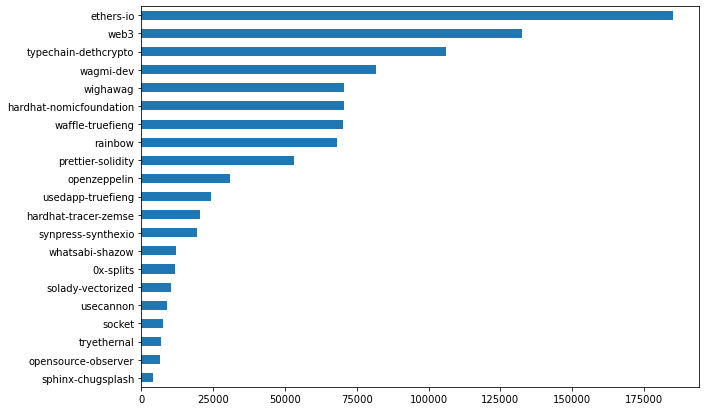

In [9]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [10]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [11]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)